In [1]:
import pandas as pd  # For dataframe
import numpy as np  # For matrix operations
import sklearn.preprocessing as sklpre  # For preprocessing (scaling)
import sklearn.linear_model as skllm  # For OLS
import sklearn.model_selection as sklms  # For train_test_split
from scipy import stats  # To calc p-value
import matplotlib.pyplot as plt  # For plotting

# For automatic formatting of code, sparing you from my usually horrible looking code
%load_ext nb_black

<IPython.core.display.Javascript object>

# Task 1.1
I have chosen to one-hot encode the SEX-category, as neither male nor female should be considered adifferent numbers. 
The rest of the categorical values are just true/false, so those aren't encoded. 
Then I scale all the scalar features, not touching the categorical features.

In [2]:
# Reading the data into dataframe
df = pd.read_csv("data_task_1.txt", header=0, sep=" ")
# Onehot-encoding gender
onehot_gender = pd.get_dummies(df["SEX"]).set_axis(
    ["Male", "Female"], axis=1, inplace=False
)
# Replacing old gender column
df = df.join(onehot_gender)
df.drop("SEX", axis=1, inplace=True)
# List of boolean categories
categorical = [
    "ADHEU",
    "HOCHOZON",
    "AMATOP",
    "AVATOP",
    "ADEKZ",
    "ARAUCH",
    "FSNIGHT",
    "FSPT",
    "FSATEM",
    "FSAUGE",
    "FSPFEI",
    "FSHLAUF",
    "Male",
    "Female",
]

# A loop that splits the data and tries again until there is no split where only one modality is in one split
first = True
while (
    first
    or np.any(
        np.logical_or(X_train.sum(axis=0) == 0, X_train.sum(axis=0) == X_train.shape[0])
    )
    or np.any(
        np.logical_or(X_test.sum(axis=0) == 0, X_test.sum(axis=0) == X_test.shape[0])
    )
):
    first = False
    # Splitting over and over until splits are good, stratifying the most biased feature.
    X_train, X_test, y_train, y_test = sklms.train_test_split(
        df.loc[:, df.columns != "FFVC"],
        df["FFVC"],
        test_size=0.5,
        stratify=df["FSATEM"],
    )
# Scaling scalar features based on train set
scaler = sklpre.StandardScaler()
X_train_continous = scaler.fit_transform(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))].values
)
X_test_continous = scaler.transform(
    X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))].values
)
# Putting all scalar and categorical features together
X_train.loc[
    :, np.logical_not(np.isin(X_train.columns, categorical))
] = X_train_continous
X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))] = X_test_continous
# All preprocessing done!

<IPython.core.display.Javascript object>

# Task 1.2
Running OLS, calculating uncertainties and p-values

In [3]:
def get_summary_linear_model(model, X_train, y_train):
    """
    Scikit-learn has no built in support for confidence intervals and p-values, so I 
    made this to calculate it for me after fitting the model. Put into a function for reuse.
    """
    # Combining intercept and coefficients in same array
    coefficients = np.append(model.intercept_, model.coef_)

    # Predicting y
    y_hat = model.predict(X_train)
    # Calculating RSS to get variance for use when calculating stddev of coeffs
    residuals = y_train.values - y_hat
    rss = residuals.reshape(-1, 1).T @ residuals.reshape(-1, 1)
    var = rss[0, 0] / (len(X_train) - len(X_train.columns) - 1)

    # Adding intercept to X_train, as sklearn usually does not need the column of 1's
    X_with_intercept = np.append(
        np.ones(X_train.shape[0]).reshape(-1, 1), X_train, axis=1
    )
    # Stddev of coefficients
    stddev = np.sqrt(
        (np.diag(var * np.linalg.pinv(X_with_intercept.T @ X_with_intercept)))
    )
    labels = ["Intercept"] + X_train.columns.tolist()

    coef_over_std = coefficients / stddev
    p_values = [
        2 * (1 - stats.t.cdf(np.abs(i), (len(X_with_intercept) - 1)))
        for i in coef_over_std
    ]

    # Putting results into table
    coeffs_table = pd.DataFrame(zip(labels, coefficients, stddev, p_values))
    # Giving nice names with TeX formatting
    coeffs_table.rename(
        columns={0: "Feature", 1: r"$\beta_i$", 2: r"$\pm$", 3: "p-values"},
        inplace=True,
    )
    return coeffs_table

<IPython.core.display.Javascript object>

In [4]:
# OLS on train data
ols_reg = skllm.LinearRegression().fit(X_train, y_train)
# R2 test score
r2 = ols_reg.score(X_test, y_test)
# Using the function in the above cell to get table
coeffs_table = get_summary_linear_model(ols_reg, X_train, y_train)
# Using Numpy indexing stuff to get feature with lowest p-value
most_important = coeffs_table["Feature"].values[1:][
    np.argmin(coeffs_table["p-values"].values[1:])
]
# Printing results
print(f"Got an R^2 score of {r2:.2f} for the test set.")
print(f"The most important feature (lowest p-value) is {most_important}.")
coeffs_table

Got an R^2 score of 0.60 for the test set.
The most important feature (lowest p-value) is FLGROSS.


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.364216,0.027269,0.000000e+00
1,ALTER,0.017773,0.017561,3.124780e-01
2,ADHEU,-0.063809,0.060722,2.943574e-01
3,HOCHOZON,-0.121314,0.040104,2.749271e-03
4,AMATOP,-0.011100,0.032427,7.324030e-01
5,AVATOP,-0.017774,0.033571,5.969704e-01
6,ADEKZ,-0.031533,0.035637,3.771026e-01
7,ARAUCH,-0.009976,0.032260,7.573923e-01
8,AGEBGEW,0.011899,0.014934,4.263524e-01
9,FSNIGHT,0.030147,0.051487,5.587234e-01


<IPython.core.display.Javascript object>

The most important (lower p-value) feature seems to be FLGROSS. Some other important features seem to be gender. Male and female seem to completely cancel each other, implying that men are of higher risk?

# Task 1.3
Scikit-learn for some reason doesn't have built in forward and backward selection, so I will create my own functions!

In [5]:
def backward_elimination(regressor, X_train, y_train, max_p_limit):
    """
    Takes a regressor, training set and a max p-value, runs backward
    elimination and returns the regresson fitted on the reduced
    features, the reduced feature matrix, a table of betas, 
    standard deviations and p-values and the removed features
    """
    # Fitting regressor on full model
    regressor.fit(X_train, y_train)
    # Getting table of p-values to find what to eliminate
    result_table = get_summary_linear_model(regressor, X_train, y_train)
    p_values = result_table["p-values"].values
    p_val_max, p_val_max_pos = p_values[1:].max(), p_values[1:].argmax() + 1
    # Getting name of feature with highest p-val to make list of removed features
    feature_max_p_val = result_table["Feature"][p_val_max_pos]
    removed_features = [feature_max_p_val]
    # Dropping feature with highest p-val
    X_reduce = X_train.drop(columns=feature_max_p_val, inplace=False)
    # Running backwards elimination until all p-values are below limit
    while p_val_max > max_p_limit:
        # Fitting on reduced model
        regressor.fit(X_reduce, y_train)
        result_table = get_summary_linear_model(regressor, X_reduce, y_train)
        p_values = result_table["p-values"].values
        p_val_max, p_val_max_pos = p_values[1:].max(), p_values[1:].argmax() + 1
        feature_max_p_val = result_table["Feature"][p_val_max_pos]
        # If one or more features have to high p-value, remove
        if p_val_max > max_p_limit:
            # Append name to list that keeps track of removed features
            removed_features.append(feature_max_p_val)
            # Dropping feature
            X_reduce.drop(columns=feature_max_p_val, inplace=True)
            # Sorting features
            X_reduce.sort_index(axis=1, inplace=True)
            # Fitting reduced model
            regressor.fit(X_reduce, y_train)

    return regressor, X_reduce, result_table, removed_features

<IPython.core.display.Javascript object>

In [6]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running backwards elimination
(
    regressor_reduced,
    X_reduce_train,
    result_table_reduced,
    removed_features,
) = backward_elimination(base_regressor, X_train, y_train, max_p_limit=1e-2)
# Using list of reduced features to also create test feature matrix with same features
X_reduce_test = X_test.drop(columns=removed_features).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of full model: {ols_reg.score(X_test, y_test):.2f} Backward Model: {regressor_reduced.score(X_reduce_test, y_test):.2f}"
)
result_table_reduced

R^2 score of full model: 0.60 Backward Model: 0.61


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.337186,0.015915,0.000000e+00
1,FLGEW,0.087173,0.021256,5.582698e-05
2,FLGROSS,0.190917,0.021817,2.220446e-16
3,FNOH24,-0.045487,0.016242,5.503514e-03
4,FSPFEI,0.160057,0.056114,4.707088e-03
5,Female,-0.084221,0.016172,4.026660e-07
6,HOCHOZON,-0.085258,0.032370,8.975990e-03
7,Male,0.084221,0.016481,6.450400e-07


<IPython.core.display.Javascript object>

In [7]:
def forward_selection(regressor, X_train, y_train, max_p_limit):
    """
    Takes a regressor, training set and a max p-value, runs forward
    selection and returns the regresson fitted on the reduced
    features, the reduced feature matrix, a table of betas, 
    standard deviations and p-values and the removed features
    """
    X_null = pd.DataFrame({"null": np.zeros_like(y_train)})
    regressor.fit(X_null, y_train)
    # The p-value for the 0-column is invalid, but also not used, so I ignore the warnings
    with np.errstate(invalid="ignore"):
        # Getting results for null-model
        result_table = get_summary_linear_model(regressor, X_null, y_train)
    # p-value for intercept
    p_val_max = result_table["p-values"][0]
    # Dataframe used for incresing
    X_increased = pd.DataFrame()
    # List of features
    features = X_train.columns.values
    # while max p-val is below threshold, repeat
    while p_val_max < max_p_limit:
        # Set best p to infinity so that all values are less
        best_p = np.inf
        # Looping over features
        for feature in features:
            # Creating new column with feature in loop
            new_col = pd.DataFrame({feature: X_train[feature].values})
            # If null model we need to append to the dataframe differently than usual
            if len(X_increased.values) == 0:
                # Adding new feature to null model
                X_candidate = X_increased.append(new_col)
            else:
                # Adding new feature to model
                new_col_names = np.append(
                    X_increased.columns.values, new_col.columns.values
                )
                X_candidate = pd.DataFrame(
                    np.append(X_increased.values, new_col.values, axis=1),
                    columns=new_col_names,
                )
            # Fitting increased model to find p-value
            regressor.fit(X_candidate, y_train)
            result_table = get_summary_linear_model(regressor, X_candidate, y_train)
            p_i = result_table["p-values"].values[-1]
            # This if-statement is used to find the minimum p-value of the potential features to add
            if p_i < best_p:
                best_p = p_i
                best_new_feature = feature
        # Now that we have the best feature to add, we add it properly
        new_col = pd.DataFrame({best_new_feature: X_train[best_new_feature].values})
        if len(X_increased.values) == 0:
            X_candidate = X_increased.append(new_col)
        else:
            new_col_names = np.append(
                X_increased.columns.values, new_col.columns.values
            )
            X_candidate = pd.DataFrame(
                np.append(X_increased.values, new_col.values, axis=1),
                columns=new_col_names,
            )
        # Get results for new model
        result_table = get_summary_linear_model(regressor, X_candidate, y_train)
        p_val_max = result_table["p-values"].values.max()

        # Sorting features
        X_increased = X_candidate.sort_index(axis=1)
        # Removing added feature from list of potential featues so that we can't add it again next iteration
        features = features[features != best_new_feature]

    # List of omitted features
    omitted_features = features
    # Fitting increased model
    regressor.fit(X_increased, y_train)
    # Table of results for best model
    result_table_best = get_summary_linear_model(regressor, X_increased, y_train)
    return regressor, X_increased, result_table_best, omitted_features

<IPython.core.display.Javascript object>

In [8]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased,
    X_increased_train,
    result_table_increased,
    omitted_features_increased,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-2)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test = X_test.drop(columns=omitted_features_increased).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased.score(X_increased_test, y_test):.2f}"
)
result_table_increased

R^2 score of forward model: 0.62


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.288028,0.009545,0.000000e+00
1,FLGEW,0.081910,0.021383,1.621706e-04
2,FLGROSS,0.197607,0.021644,0.000000e+00
3,FSATEM,0.163249,0.063049,1.019037e-02
4,Female,-0.092164,0.014655,1.440385e-09
5,Male,0.092164,0.015432,8.098835e-09


<IPython.core.display.Javascript object>

For the reduced models with $p_\text{max}=0.01$, both forward and backward selection give the exact same model, and therefore the same features. They also get a slightly better $R^2$-score, possibly because they have less features, and are therefore less likely to overfit on the training data. I chose to look at $R^2$ instead of MSE as I feel it is a more intuitive value. However, higher $R^2$ also implies lower MSE, so the models are better.

Next I will test with a less strict $p_\text{max}=0.1$ and see how the models perform:

In [9]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running backwards elimination
(
    regressor_reduced_less_strict,
    X_reduce_train_less_strict,
    result_table_reduced_less_strict,
    removed_features_less_strict,
) = backward_elimination(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_reduce_test_less_strict = X_test.drop(
    columns=removed_features_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of full model: {ols_reg.score(X_test, y_test):.2f}"
    + f" Backward Model: {regressor_reduced_less_strict.score(X_reduce_test_less_strict, y_test):.2f}"
)
result_table_reduced_less_strict

R^2 score of full model: 0.60 Backward Model: 0.59


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.356130,0.017614,0.000000e+00
1,FLGEW,0.085413,0.020977,6.284887e-05
2,FLGROSS,0.185501,0.021658,1.110223e-15
3,FNOH24,-0.059083,0.018648,1.726465e-03
4,FO3H24,0.066141,0.032154,4.073414e-02
5,FSATEM,0.115505,0.069290,9.678552e-02
6,FSPFEI,0.139534,0.062715,2.699165e-02
7,FTEH24,-0.052844,0.029422,7.370182e-02
8,FTIER,-0.034312,0.013747,1.321092e-02
9,Female,-0.092246,0.016138,3.133708e-08


<IPython.core.display.Javascript object>

In [10]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased_less_strict,
    X_increased_train_less_strict,
    result_table_increased_less_strict,
    omitted_features_increased_less_strict,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test_less_strict = X_test.drop(
    columns=omitted_features_increased_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased.score(X_increased_test, y_test):.2f}"
)
result_table_increased_less_strict

R^2 score of forward model: 0.62


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.288028,0.009545,0.000000e+00
1,FLGEW,0.081910,0.021383,1.621706e-04
2,FLGROSS,0.197607,0.021644,0.000000e+00
3,FSATEM,0.163249,0.063049,1.019037e-02
4,Female,-0.092164,0.014655,1.440385e-09
5,Male,0.092164,0.015432,8.098835e-09


<IPython.core.display.Javascript object>

Now the models are not the same anymore. This is to be expected, as the p-values estimated are not the same for each feature independent of the other features. The backward elimination model seems to give a better $R^2$-score this time.

# Task 1.4
CV is easily implemented in Scikit-Learn. Bootstap on the other hand... I need to create my own class (Maybe there is a better way of doing this than what I'm doing...)

In [44]:
# 5-fold cross validation, n-jobs=-1 is for parallelisation (use multiple cpu cores)
lasso_cv = skllm.LassoCV(n_jobs=-1, cv=5).fit(X_train, y_train)
# List of hyperparameters
lambdas_lasso_cv = lasso_cv.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 5 folds
mses_lasso_cv = lasso_cv.mse_path_.mean(axis=1)
print(
    f"Best hyperparameter is {lasso_cv.alpha_:.2e}, giving a test R^2 score of {lasso_cv.score(X_test, y_test):.2f}"
)

Best hyperparameter is 3.98e-03, giving a test R^2 score of 0.62


<IPython.core.display.Javascript object>

This seems to be very similar to forward and backward selection. Now I need to make a new class for bootstrap manually implemented.

In [45]:
class Bootstrap:
    def __init__(self, y):
        """
        I was sort of confused on how to this, so I just made a class and tried stuff. 
        Now it works, so I won't change it anymore.
        This class takes y_train and saves its length.
        """
        self.len_y = len(y)

    @property
    def get_bootstrap(self):
        """
        This method returns one train-validation bootstrap split of the training data (indices of the data).
        The @property is just so that i can call get_bootstrap without the () after (like in get_bootstrap()).
        This splits train and validation into 2/3, 1/3 of the length of the data. Not sure if that is the correct
        method.
        """
        # All indices (0-lenght of y)
        indices = np.arange(self.len_y)
        # Picking random indices with replacement.
        indices_train = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.67)
        )
        indices_validate = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.37)
        )
        # Returns a list of lists
        return [indices_train.tolist(), indices_validate.tolist()]


# Creating instance of Bootstrap class
bootstrap = Bootstrap(y_train)
splits = []
# This loops creates 100 different bootstrap samples
for i in range(100):
    splits.append(bootstrap.get_bootstrap)
# Running LassoCV with bootstrap instead of CV.
lasso_bootstrap = skllm.LassoCV(n_jobs=-1, cv=splits).fit(X_train, y_train)

# Lambdas tried by the solver
lambdas_lasso_bootstrap = lasso_bootstrap.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 100 bootstraps
mses_lasso_bootstrap = lasso_bootstrap.mse_path_.mean(axis=1)

print(
    f"Best hyperparameter is {lasso_bootstrap.alpha_:.2e}, giving a test R^2 score of {lasso_bootstrap.score(X_test, y_test):.2f}"
)

Best hyperparameter is 3.71e-03, giving a test R^2 score of 0.62


<IPython.core.display.Javascript object>

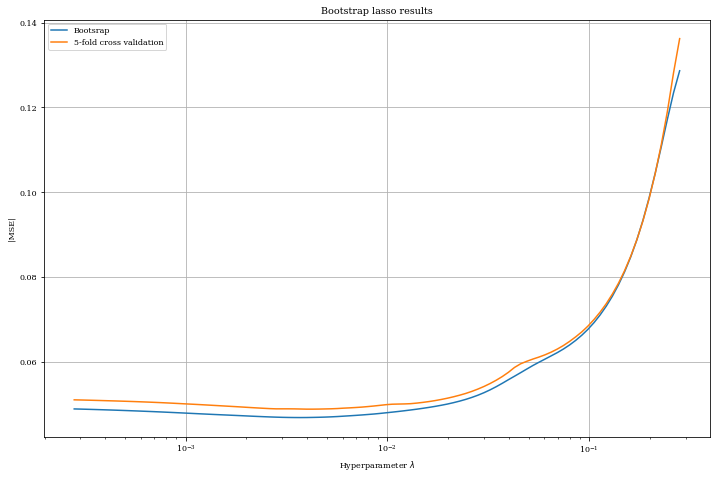

<IPython.core.display.Javascript object>

In [56]:
fonts = {
    "font.family": "serif",
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(fonts)

# Log plot
plt.figure(figsize=(10, 6.7))
plt.semilogx(lambdas_lasso_bootstrap, mses_lasso_bootstrap, label="Bootsrap")
plt.semilogx(lambdas_lasso_cv, mses_lasso_cv, label="5-fold cross validation")
plt.xlabel(r"Hyperparameter $\lambda$")
plt.ylabel(r"|MSE|")
plt.title("Bootstrap lasso results")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()